In [29]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img, smooth_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats.mstats import pearsonr

Okay, as I understand it: 
1) Mean center valence and arousal scores. 
2) To obtain positive and negative arousal scores use 
- Pos_arousal -> (arousal_i - valence_i)/sqrt(2)
- Neg_arousal -> (arousal_i - valence_i)/sqrt(2)

# Homemade functions

In [30]:
def Merge(dict1, dict2):

    # create a new dictionary by merging the items of the two dictionaries using the union operator (|)
    merged_dict = dict(dict1.items() | dict2.items())
    
    # return the merged dictionary
    return merged_dict

def merge_dictionaries(dict1, dict2):
    merged_dict = dict1.copy()
    merged_dict.update(dict2)
    return merged_dict

In [31]:
# Define a function to invert scores if needed. 
def transform_scores(score, invert):
    if(not invert):
        if(score == 1):  
            return 4
        elif(score == 2):  
            return 3
        elif(score == 3):  
            return 2
        elif(score == 4):  
            return 1
        elif(score == "1"):  
            return 4
        elif(score == "2"):  
            return 3
        elif(score == "3"):  
            return 2
        elif(score == "4"):  
            return 1
        elif(score == "None"):
            return 0
        else: 
            return "Something went wrong here!"
    else:
        if(score == "1"):
            return 1
        elif(score == "2"):
            return 2
        elif(score == "3"):
            return 3
        elif(score == "4"):
            return 4
        elif(score == 1):
            return 1
        elif(score == 2):
            return 2
        elif(score == 3):
            return 3
        elif(score == 4):
            return 4
        elif(score == "None"):
            return 0
        else:
            return "Something went wrong here!"

In [32]:
# Percent signal change .
def get_psc(timecourse):

   # Get number of ROIs and data points in timecourse.
   roi_num = timecourse.shape[1]
   data_length = timecourse.shape[0]

   # Copy timecourse into new array.
   psc_timecourse = np.zeros(timecourse.shape)

   # Warning for empty arrays. 
   if(roi_num ==0):
      print("Watch out, this array is empty!")

   # Loop through every ROI and derive the psc. 
   for id in range(roi_num):

      current_roi_avg = np.mean(timecourse[:, id], axis=0)

      for idx in range(data_length):

         # Formula to get percent signal change -> ((point-avg)/avg)*100.
         psc_timecourse[idx, id] = ((timecourse[idx, id] - current_roi_avg)/ current_roi_avg)*100

   return psc_timecourse

In [33]:
def process_events_data(run_dataframe):

    proccesed_events_df = pd.DataFrame(columns={"Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"}) 

    # Initial fixation 12 sec (TR=6).
    in_fix = 12

    # Time it take subjects to complete questionnaire 12 sec (TR=6). 
    questionnaire_duration = 12

    # All trailers last 30 sec (TR=15). 
    trailer_duration = 30

    # Initialize this variable, though it will change through each iteration of the loop.
    trailer_onset = 0

    # Run a for loop for each row in the df. 
    for id in range(run_dataframe.shape[0]):

        # Get trailer label and separate them accroding to their type. 
        trailer_name = run_dataframe["label"][id]
        trailer_type = "Horror" if "h" in run_dataframe["label"][id] else "Comedy"

        # This onsets don't work, so I need to re-calculate them
        traile_iti = run_dataframe["trial_ITI"][id]
        
        # For the first run add the initial fixation time to the calculation of the first trailer onset. 
        # After the first run, calculate onset by adding previous traile onset, questionnaire duration, and trial iti.
        if (id == 0):
            trailer_onset += in_fix
        else:
            trailer_onset += trailer_duration + questionnaire_duration + traile_iti

        # Calculate trailer onset. 
        trailer_offset = trailer_onset + 30 

        """ 
        For the questionnaire scores, as I understood it. If they were not inverted (["scale_flip"] == 0), then 
        the lower the score the stronger the response. If they were inverted (["scale_flip"] == 1), the higher the 
        score the stronger the response.
        """
        # Check if scaled was flipped and put scores on the same scale. 
        # For me, the most intuitive is that the higher the score, the stronger the response. 
        trailer_watch_score = transform_scores(run_dataframe["exp_Watch.keys"][id], run_dataframe["scale_flip"][id])
        trailer_arousal_score = transform_scores(run_dataframe["exp_Arousal.keys"][id], run_dataframe["scale_flip"][id])
        trailer_feel_score = transform_scores(run_dataframe["exp_Feel.keys"][id], run_dataframe["scale_flip"][id])

        # Place processed data on list, add list to new dataframe, and concat to main dataframe. 
        current_row_data = [[trailer_name, trailer_type, trailer_onset, trailer_duration, trailer_offset, trailer_watch_score, trailer_arousal_score, trailer_feel_score]]
        current_row = pd.DataFrame(data=current_row_data, columns=["Trailer", "Type", "Onset", "Duration", "Offset", "W_score", "A_score", "F_score"]) 
        proccesed_events_df = pd.concat([proccesed_events_df, current_row], ignore_index=True)
        proccesed_events_df = proccesed_events_df[["Trailer", "Type", "Onset", "Offset", "Duration", "W_score", "A_score", "F_score"]]

    # Add a column for the mean centered arousal and valence scores.
    mean_centered_arousal = proccesed_events_df["A_score"]/proccesed_events_df["A_score"].mean()
    mean_centered_valence = proccesed_events_df["W_score"]/proccesed_events_df["W_score"].mean()

    # Derive the positive and negative arousal scores.
    proccesed_events_df["Pos_arousal"] = (mean_centered_arousal+mean_centered_valence)/np.sqrt(2)
    proccesed_events_df["Neg_arousal"] = (mean_centered_arousal-mean_centered_valence)/np.sqrt(2)

    return proccesed_events_df

In [34]:
def trim_timecourse_per_roi(timecourses_dictionary_list, particpants_list, ROI):

    # 1) Create a new dictionary to store the trimmed timecourses.
    # First file will store the avg timecourse for each trailer per roi (ROI x trailer).
    # Second file will store the timecourse of all subjects for each trailer per roi (ROI x subjects x trailer).
    # Third file will store the timecourse of all subjects for each trailer per roi in a dataframe (ROI x subjects x trailer).
    all_subjects_avg_ROI_timecourse = {}
    all_subjects_ROI_timecourse = {}
    all_subjects_ROI_timecourse_df = {}

    bROI = "Bilateral_" + ROI
    rROI = "Right_" + ROI
    lROI = "Left_" + ROI

    # Get all keys from the first participant dictionary.
    keys = list(timecourses_dictionary_list[0].keys())

    # Loop through all trailer keys.
    for id in range(len(keys)): 
    
        # Get the corresponding values from all participant dictionaries
        values = [d[keys[id]] for d in timecourses_dictionary_list]
        values_Bilateral_ROI = [values[d][bROI] for d in range(len(values))]
        values_Right_ROI = [values[d][rROI] for d in range(len(values))]
        values_Left_ROI = [values[d][lROI] for d in range(len(values))]

        # Compute the average for each roi.
        averageBilateral_ROI = np.mean(values_Bilateral_ROI, axis=0)
        averageRight_ROI = np.mean(values_Right_ROI, axis=0)
        averageLeft_ROI = np.mean(values_Left_ROI, axis=0)

        # Row are timepoints, columns are participants (15 x 5).
        values_Bilateral_ROI_array = np.array(values_Bilateral_ROI).T 
        values_Right_ROI_array = np.array(values_Right_ROI).T
        values_Left_ROI_array = np.array(values_Left_ROI).T

        # Create columns names for the dataframe.
        #col_names = [str("sub-" + particpants_list[d]) for d in range(len(particpants_list))]
        TRs = np.arange(0, 15, 1)

        # Creat empty dataframe for current trailer. 
        trailer_df = pd.DataFrame(columns=["Participant", "ROI", "Signal", "TR"])   

        current_participant_dic = {}

        for current_participant in range(len(particpants_list)):

            # Create dictionary with all the timecourses for all trailers for each subject.
            current_participant_dic[str("sub-" + particpants_list[current_participant])] = {bROI: values_Bilateral_ROI_array[:, current_participant], lROI: values_Left_ROI_array[:, current_participant], rROI: values_Right_ROI_array[:, current_participant]}
 
            participant_col = np.repeat(str("sub-" + particpants_list[current_participant]), 15)
            label_bi = np.repeat(bROI, 15)
            label_left = np.repeat(lROI, 15)
            label_right = np.repeat(rROI, 15)
            roi_labels = [label_bi, label_left, label_right]

            # Store current participant values. 
            current_participant_bi = values_Bilateral_ROI_array[:, current_participant]
            current_participant_left = values_Left_ROI_array[:, current_participant]
            current_participant_right = values_Right_ROI_array[:, current_participant]
            current_participant_values = [current_participant_bi, current_participant_left, current_participant_right]

            for x in range(3):

                current_participant_roi_data = {
                    "Participant": participant_col,
                    "ROI": roi_labels[x],
                    "Signal": current_participant_values[x],
                    "TR": TRs
                }
            
                participant_df = pd.DataFrame(data=current_participant_roi_data)

                trailer_df = pd.concat([trailer_df, participant_df], ignore_index=True)
        
        # store the all in the results dictionaries.
        all_subjects_avg_ROI_timecourse[keys[id]] = {bROI: averageBilateral_ROI, lROI: averageLeft_ROI, rROI: averageRight_ROI}
        all_subjects_ROI_timecourse[keys[id]] = current_participant_dic
        all_subjects_ROI_timecourse_df[keys[id]] = trailer_df

    return all_subjects_avg_ROI_timecourse, all_subjects_ROI_timecourse, all_subjects_ROI_timecourse_df

In [35]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets


In [36]:

def getROI_PSC_timecourse(participant_num): 

    # Add code to flag if something that is not a number is passed. 

    ## 1) Load data.
    # Load relevant files for participant
    sub_run1_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    sub_run2_func_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"

    sub_run1_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"
    sub_run2_mask_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"

    sub_run1_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_events.csv"
    sub_run2_events_path = "MovieData_BIDS_raw/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-02_events.csv"

    sub_run1_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"
    sub_run2_confounds_path = "MovieData_BIDS_preproc/sub-" + participant_num + "/func/sub-" + participant_num + "_task-movie_run-01_desc-confounds_timeseries.tsv"

    # Calculate relevant parameters for GLM and ROI time-course analysis.
    func_file = nib.load(sub_run1_func_path)
    func_data = func_file.get_fdata()
    n_vols = func_data.shape[3]
    TR = 2
    n_timepoints = n_vols*TR

    # Load raw events files. 
    sub_run1_events_df = pd.read_csv(sub_run1_events_path, index_col=0)
    sub_run2_events_df = pd.read_csv(sub_run2_events_path, index_col=0)

    ## 2) Process files. 
    # Process event files. 
    sub_run1_p_events = process_events_data(sub_run1_events_df)
    sub_run2_p_events = process_events_data(sub_run2_events_df)

    # Create new dataframes with all the processed events.
    sub_all_p_events = pd.concat([sub_run1_p_events, sub_run2_p_events], ignore_index=True)


    # Down-sample time onsets to get vol onsets. 
    # Create array from 0 to 'n_timepoints' in steps of 1.
    time_scale = np.arange(0, n_timepoints, 1)  

    # Create array from 0 to 'n_timepoints' in steps of 2.
    vol_scale = np.arange(0, n_timepoints, TR)  

    # Get the labels of each trailer for each run. 
    run1_trailer_labels = sub_run1_p_events["Trailer"].tolist()
    run2_trailer_labels = sub_run2_p_events["Trailer"].tolist()

    # Create dictionary variable to store arrays with onset values for each trailer. 
    run1_onsets = {}
    run2_onsets = {}

    # Create a dictionary with all the onsets for each trailer in each run. 
    for id in range(len(run1_trailer_labels)):

        # Create array of zeros.
        run1_trailer_onsets = np.zeros(n_timepoints)
        run2_trailer_onsets = np.zeros(n_timepoints)

        # Get onset time. 
        run1_current_trailer_onset = sub_run1_p_events["Onset"][id]
        run2_current_trailer_onset = sub_run2_p_events["Onset"][id]

        # Assign 1 to such onset all the way til the end of the trailer (30 sec) in the array of zeros.
        # Adjust for lag: add 4 seconds at the onset and offset
        run1_trailer_onsets[int(run1_current_trailer_onset + 4):int(run1_current_trailer_onset)+ 30 + 4] = 1
        run2_trailer_onsets[int(run2_current_trailer_onset + 4):int(run2_current_trailer_onset)+ 30 + 4] = 1

        # Create resampler objects for each trailer/run of reward.
        run1_resampler = interp1d(time_scale, run1_trailer_onsets)
        run2_resampler = interp1d(time_scale, run2_trailer_onsets)

        # Create downsampled arrays for each trailer. 
        # Note this vol arrays are half the length than the time arrays.
        run1_trailer_vol_onsets = run1_resampler(vol_scale)
        run2_trailer_vol_onsets = run2_resampler(vol_scale)

        # Append/store the downsampled volumes arrays to each dictionary.
        # I'm doing it this way, so the code is more interpretable
        run1_onsets[run1_trailer_labels[id]] = run1_trailer_vol_onsets
        run2_onsets[run2_trailer_labels[id]] = run2_trailer_vol_onsets

    ## 3) Load confound data. 
    sub_run1_confounds_df = pd.read_csv(sub_run1_confounds_path, sep='\t')
    sub_run2_confounds_df = pd.read_csv(sub_run2_confounds_path, sep='\t')
    default_confounds = ["white_matter", "csf", "csf_wm", "framewise_displacement", "dvars", "rmsd", "cosine00", "tcompcor"]
    
    cohen_confounds = ['c_comp_cor_00','c_comp_cor_01','c_comp_cor_02','w_comp_cor_00','w_comp_cor_01','w_comp_cor_02','w_comp_cor_03','w_comp_cor_04','trans_x','trans_y','trans_z','rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1','rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2','rot_x_power2','rot_y_power2','rot_z_power2','trans_x_derivative1_power2','trans_y_derivative1_power2','trans_z_derivative1_power2','rot_x_derivative1_power2','rot_y_derivative1_power2','rot_z_derivative1_power2']
    #['trans_y', 'trans_x', 'trans_z', 'rot_y', 'rot_x', 'rot_z', #"global_signal", "csf", "white_matter", "csf_wm",  "framewise_displacement", "dvars"]
    #                    "white_matter", "csf", "csf_wm",  "framewise_displacement", "dvars"]

    sub_run1_motion_s_confounds = [i for i in sub_run1_confounds_df.columns if "state" in i] #"motion"
    sub_run2_motion_s_confounds = [i for i in sub_run2_confounds_df.columns if "state" in i] 

    sub_run1_motion_rot_confounds = [i for i in sub_run1_confounds_df.columns if "rot" in i] 
    sub_run2_motion_rot_confounds = [i for i in sub_run2_confounds_df.columns if "rot" in i] 

    sub_run1_motion_trans_confounds = [i for i in sub_run1_confounds_df.columns if "trans" in i] 
    sub_run2_motion_trans_confounds = [i for i in sub_run2_confounds_df.columns if "trans" in i] 

    sub_run1_filtered_confounds_df = sub_run1_confounds_df[default_confounds + sub_run1_motion_s_confounds + sub_run1_motion_rot_confounds + sub_run1_motion_trans_confounds]
    sub_run2_filtered_confounds_df = sub_run2_confounds_df[default_confounds + sub_run2_motion_s_confounds + sub_run2_motion_rot_confounds + sub_run2_motion_trans_confounds]

    sub_run1_cohen_confounds_df = sub_run1_confounds_df[cohen_confounds]
    sub_run2_cohen_confounds_df = sub_run2_confounds_df[cohen_confounds]

    # Change NaNs to 0s. 
    sub_run1_filtered_confounds_df = sub_run1_filtered_confounds_df.fillna(0) 
    sub_run2_filtered_confounds_df = sub_run2_filtered_confounds_df.fillna(0) 

    sub_run1_cohen_confounds_df = sub_run1_cohen_confounds_df.fillna(0) 
    sub_run2_cohen_confounds_df = sub_run2_cohen_confounds_df.fillna(0) 

    ## 4) Apply mask to func data. 
    masker_AIM_ROI_r1 = NiftiSpheresMasker(
        seeds=[(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
        (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
        (4, 45, 0), (-4, 45, 0)], # Medial Prefrontal Cortex (MPFC) right, left
        allow_overlap=True,
        smoothing_fwhm=4, # Applying a Gaussian filter with a 4mm kernel
        detrend=False,
        radius=8, 
        mask_img=sub_run1_mask_path,
        standardize="psc", 
        t_r=2,
        standardize_confounds="psc",
        high_pass=1/360, # High cutoff frequency in Hertz.
        #low_pass=0.1 # from 1.0
        )

    masker_AIM_ROI_r2 = NiftiSpheresMasker(
        seeds=[(10, 12, -2), (-10, 12, -2), # Nucleus accumbes (NAcc) right, left
        (34, 24, -4), (-34, 24, -4), # Anterior Insula right (AIns), left
        (4, 45, 0), (-4, 45, 0)], # Medial Prefrontal Cortex (MPFC) right, left
        allow_overlap=True,
        smoothing_fwhm=4, # Applying a Gaussian filter with a 4mm kernel
        detrend=False,
        radius=8, 
        mask_img=sub_run2_mask_path,
        standardize="psc", 
        t_r=2,
        standardize_confounds="psc",
        high_pass=1/360, # High cutoff frequency in Hertz.
        #low_pass=0.1 # from 1.0
        )

    # Mask the func data and get a time series for the ROI. 
    # Note this is similar to fitting the GLM, but without the event files.
    sub_r1_AIM_ROI = masker_AIM_ROI_r1.fit_transform(sub_run1_func_path, confounds=sub_run1_filtered_confounds_df)
    sub_r2_AIM_ROI = masker_AIM_ROI_r2.fit_transform(sub_run2_func_path, confounds=sub_run2_filtered_confounds_df)

    # Apply function to get the percent signal change from each ROI timecourse. 

    ## 5) Get the timecourses from each movie trailer. 
    # Create dictionary variable to store arrays with time series arrays for each trailer. 
    run1_timeseries = {}
    run2_timeseries = {}

    # Get the trailers presented in each run. 
    r1_keys = list(run1_onsets.keys())
    r2_keys = list(run2_onsets.keys())

    # Loop through each traile and get its corresponding ROI timecourse
    # from bilateral, left, and right, NAcc.
    for id in range(len(r1_keys)):

        run1_timeseries[r1_keys[id]] = {
            "Bilateral_NAcc": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0:2], axis=1),
            "Left_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 1],
            "Right_NAcc": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 0],
            "Bilateral_AIns": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2:4], axis=1),
            "Left_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 3],
            "Right_AIns": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 2],
            "Bilateral_MPFC": np.mean(sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4:6], axis=1),
            "Left_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 5],
            "Right_MPFC": sub_r1_AIM_ROI[run1_onsets[r1_keys[id]].astype(bool)][:, 4]}
    
        run2_timeseries[r2_keys[id]] = {
            "Bilateral_NAcc": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0:2], axis=1),
            "Left_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 1],
            "Right_NAcc": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 0],
            "Bilateral_AIns": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2:4], axis=1),
            "Left_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 3],
            "Right_AIns": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 2],
            "Bilateral_MPFC": np.mean(sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4:6], axis=1),
            "Left_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 5],
            "Right_MPFC": sub_r2_AIM_ROI[run2_onsets[r2_keys[id]].astype(bool)][:, 4]}

    all_timeseries = merge_dictionaries(run1_timeseries, run2_timeseries)

    return all_timeseries, sub_all_p_events



In [37]:
sub01_ROIs_timecourse, sub01_events_df = getROI_PSC_timecourse("01") # Max-Mean FD -> Run 1: (0.911 , 0.095) Run 2: (0.571, 0.077)
sub02_ROIs_timecourse, sub02_events_df = getROI_PSC_timecourse("02") # Max-Mean FD -> Run 1: (0.663 , 0.073) Run 2: (0.734, 0.108) 
sub03_ROIs_timecourse, sub03_events_df = getROI_PSC_timecourse("03") # Max-Mean FD -> Run 1: (0.456 , 0.048) Run 2: (0.300, 0.049) 
sub04_ROIs_timecourse, sub04_events_df = getROI_PSC_timecourse("04") # Max-Mean FD -> Run 1: (0.607 , 0.080) Run 2: (0.519, 0.076) 
#sub05_NAcc_timecourse = getNAcc_timecourse("05") # Max-Mean FD -> Run 1: (1.612 , 0.138) Run 2: (1.403, 0.208)
#sub06_NAcc_timecourse = getNAcc_timecourse("06") # Max-Mean FD -> Run 1: (3.008 , 0.248) Run 2: (4.225, 0.311)
#sub07_NAcc_timecourse = getNAcc_timecourse("07") # Max-Mean FD -> Run 1: (8.275 , 0.156) Run 2: (0.531, 0.072)
sub08_ROIs_timecourse, sub08_events_df = getROI_PSC_timecourse("08") # Max-Mean FD -> Run 1: (0.597 , 0.074) Run 2: (0.482, 0.072)
sub09_ROIs_timecourse, sub09_events_df = getROI_PSC_timecourse("09") # Max-Mean FD -> Run 1: (0.367 , 0.069) Run 2: (0.475, 0.104)
sub10_ROIs_timecourse, sub10_events_df = getROI_PSC_timecourse("10") # Max-Mean FD -> Run 1: (0.597 , 0.074) Run 2: (0.679, 0.103)
sub11_ROIs_timecourse, sub11_events_df = getROI_PSC_timecourse("11") # Max-Mean FD -> Run 1: (0.540 , 0.059) Run 2: (0.394, 0.055)
sub12_ROIs_timecourse, sub12_events_df = getROI_PSC_timecourse("12") # Max-Mean FD -> Run 1: (0.649 , 0.154) Run 2: (0.529, 0.162)
sub13_ROIs_timecourse, sub13_events_df = getROI_PSC_timecourse("13") # Max-Mean FD -> Run 1: (0.468 , 0.091) Run 2: (0.459, 0.102)
#sub14_ROIs_timecourse, sub14_events_df = getROI_PSC_timecourse("14") # Max-Mean FD -> Run 1: (2.538 , 0.164) Run 2: (1.245, 0.091)
#sub15_ROIs_timecourse, sub15_events_df = getROI_PSC_timecourse("15") # Max-Mean FD -> Run 1: (0.844 , 0.066) Run 2: (1.163, 0.062)
#sub16_ROIs_timecourse, sub16_events_df = getROI_PSC_timecourse("16") # Max-Mean FD -> Run 1: (0.688 , 0.111) Run 2: (3.026, 0.218)

participant_dictionaries = [sub01_ROIs_timecourse, sub02_ROIs_timecourse, sub03_ROIs_timecourse,
                            sub04_ROIs_timecourse, sub08_ROIs_timecourse, sub09_ROIs_timecourse, 
                            sub10_ROIs_timecourse, sub11_ROIs_timecourse, sub12_ROIs_timecourse,
                            sub13_ROIs_timecourse]

participants_events = [sub01_events_df, sub02_events_df, sub03_events_df, sub04_events_df, 
                       sub08_events_df, sub09_events_df, sub10_events_df, sub11_events_df,
                       sub12_events_df, sub13_events_df]

particpants_list = ["01", "02", "03", "04", "08", "09", "10", "11", "12", "13"]

print("A total of " + str(len(participant_dictionaries)) + " participants have been processed.")



A total of 10 participants have been processed.


In [38]:
# Trim each timecourse per trailer per ROI. 
all_subjects_avg_NAcc_timecourse, all_subjects_NAcc_timecourse, all_subjects_NAcc_timecourse_df = trim_timecourse_per_roi(participant_dictionaries, particpants_list, "NAcc")
all_subjects_avg_AIns_timecourse, all_subjects_AIns_timecourse, all_subjects_AIns_timecourse_df = trim_timecourse_per_roi(participant_dictionaries, particpants_list, "AIns")
all_subjects_avg_MPFC_timecourse, all_subjects_MPFC_timecourse, all_subjects_MPFC_timecourse_df = trim_timecourse_per_roi(participant_dictionaries, particpants_list, "MPFC")



In [39]:
# Okay, the above code will get the pearson code per TR per ROI per trailer.
trailer_keys = ['rh6', 'rc2', 'uh1', 'rc9', 'rh2', 'uc4', 'rh1', 'rc6',
                'rh9', 'rc11', 'uh2', 'uc1', 'rh3', 'rc12', 'rh11', 'rc5',
                'rc3', 'rh12', 'rc1', 'rh7', 'rc8', 'rh10', 'uc3', 'rh4',
                'rc4', 'rh5', 'uc2', 'rh8', 'rc10', 'uh3', 'rc7', 'uh4']

# trailer -> Scores -> ROI -> Corrs per TR
NAcc_TR_correlations = {}
AIns_TR_correlations = {}
MPFC_TR_correlations = {}

# trailer -> Scores & ROI -> TRs (TR=1 for all participants)
Trailer_TR_Scores_dict = {}

for trailer_id in trailer_keys:

    NAcc_current_corrs = {}
    AIns_current_corrs = {}
    MPFC_current_corrs = {}

    current_trailer_dict = {}

    NAcc_TR = {}
    AIns_TR = {}
    MPFC_TR = {}

    current_trailer_w_scores = np.zeros(len(particpants_list))
    current_trailer_a_scores = np.zeros(len(particpants_list))
    current_trailer_f_scores = np.zeros(len(particpants_list))

    current_trailer_TRs = np.zeros(len(particpants_list))

    # Get the watch, arousal, and feel scores for each participant for the current trailer.
    for id in range(len(particpants_list)):
        current_trailer_w_scores[id] = participants_events[id].loc[participants_events[id]["Trailer"] == trailer_id]["W_score"]
        current_trailer_a_scores[id] = participants_events[id].loc[participants_events[id]["Trailer"] == trailer_id]["A_score"]
        current_trailer_f_scores[id] = participants_events[id].loc[participants_events[id]["Trailer"] == trailer_id]["F_score"] #[0]

    # Loop through each TR for the current trailer.
    for tr_id in range(15):

        NAcc_current_trailer_TRs_array = np.zeros(len(particpants_list))
        AIns_current_trailer_TRs_array = np.zeros(len(particpants_list))
        MPFC_current_trailer_TRs_array = np.zeros(len(particpants_list))

        # Loop through each participant for each TR for the current trailer.
        for id2 in range(len(particpants_list)):

            current_sub2 = str("sub-" + particpants_list[id2])

            NAcc_current_trailer_TRs_array[id2] = all_subjects_NAcc_timecourse[trailer_id][current_sub2]["Bilateral_NAcc"][tr_id]
            AIns_current_trailer_TRs_array[id2] = all_subjects_AIns_timecourse[trailer_id][current_sub2]["Bilateral_AIns"][tr_id]
            MPFC_current_trailer_TRs_array[id2] = all_subjects_MPFC_timecourse[trailer_id][current_sub2]["Bilateral_MPFC"][tr_id]

        # Compute the correlation between the scores and the timecourse for the current TR.
        NAcc_current_corrs[str("TR_" + str(tr_id))] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_w_scores)
        AIns_current_corrs[str("TR_" + str(tr_id))] = pearsonr(AIns_current_trailer_TRs_array, current_trailer_w_scores)
        MPFC_current_corrs[str("TR_" + str(tr_id))] = pearsonr(MPFC_current_trailer_TRs_array, current_trailer_w_scores)  
        
        #NAcc_current_TR["W_score"] = pearsonr(NAcc_current_trailer_TRs_array, current_trailer_w_scores)[0]
            
        NAcc_TR[str("TR_" + str(tr_id))] = NAcc_current_trailer_TRs_array
        AIns_TR[str("TR_" + str(tr_id))] = AIns_current_trailer_TRs_array
        MPFC_TR[str("TR_" + str(tr_id))] = MPFC_current_trailer_TRs_array
    
    current_trailer_dict["F_scores"] = current_trailer_f_scores
    current_trailer_dict["A_scores"] = current_trailer_a_scores
    current_trailer_dict["W_scores"] = current_trailer_w_scores
    current_trailer_dict["NAcc_TR"] = NAcc_TR
    current_trailer_dict["AIns_TR"] = AIns_TR
    current_trailer_dict["MPFC_TR"] = MPFC_TR

    Trailer_TR_Scores_dict[trailer_id] = current_trailer_dict

    # Store the trailer correlations in higher dict.  
    NAcc_TR_correlations[trailer_id] = NAcc_current_corrs
    AIns_TR_correlations[trailer_id] = AIns_current_corrs
    MPFC_TR_correlations[trailer_id] = MPFC_current_corrs

In [40]:
r1_keys_sorted = ['rh6', 'rc2',
                  'uh1', 'rc9',
                  'rh2', 'uc4',
                  'rh1', 'rc6',
                  'rh9', 'rc11',
                  'uh2', 'uc1',
                  'rh3', 'rc12',
                  'rh11', 'rc5']

r2_keys_sorted = ['rc3', 'rh12',
                  'rc1', 'rh7',
                  'rc8', 'rh10',
                  'uc3', 'rh4',
                  'rc4', 'rh5',
                  'uc2', 'rh8',
                  'rc10', 'uh3',
                  'rc7', 'uh4']

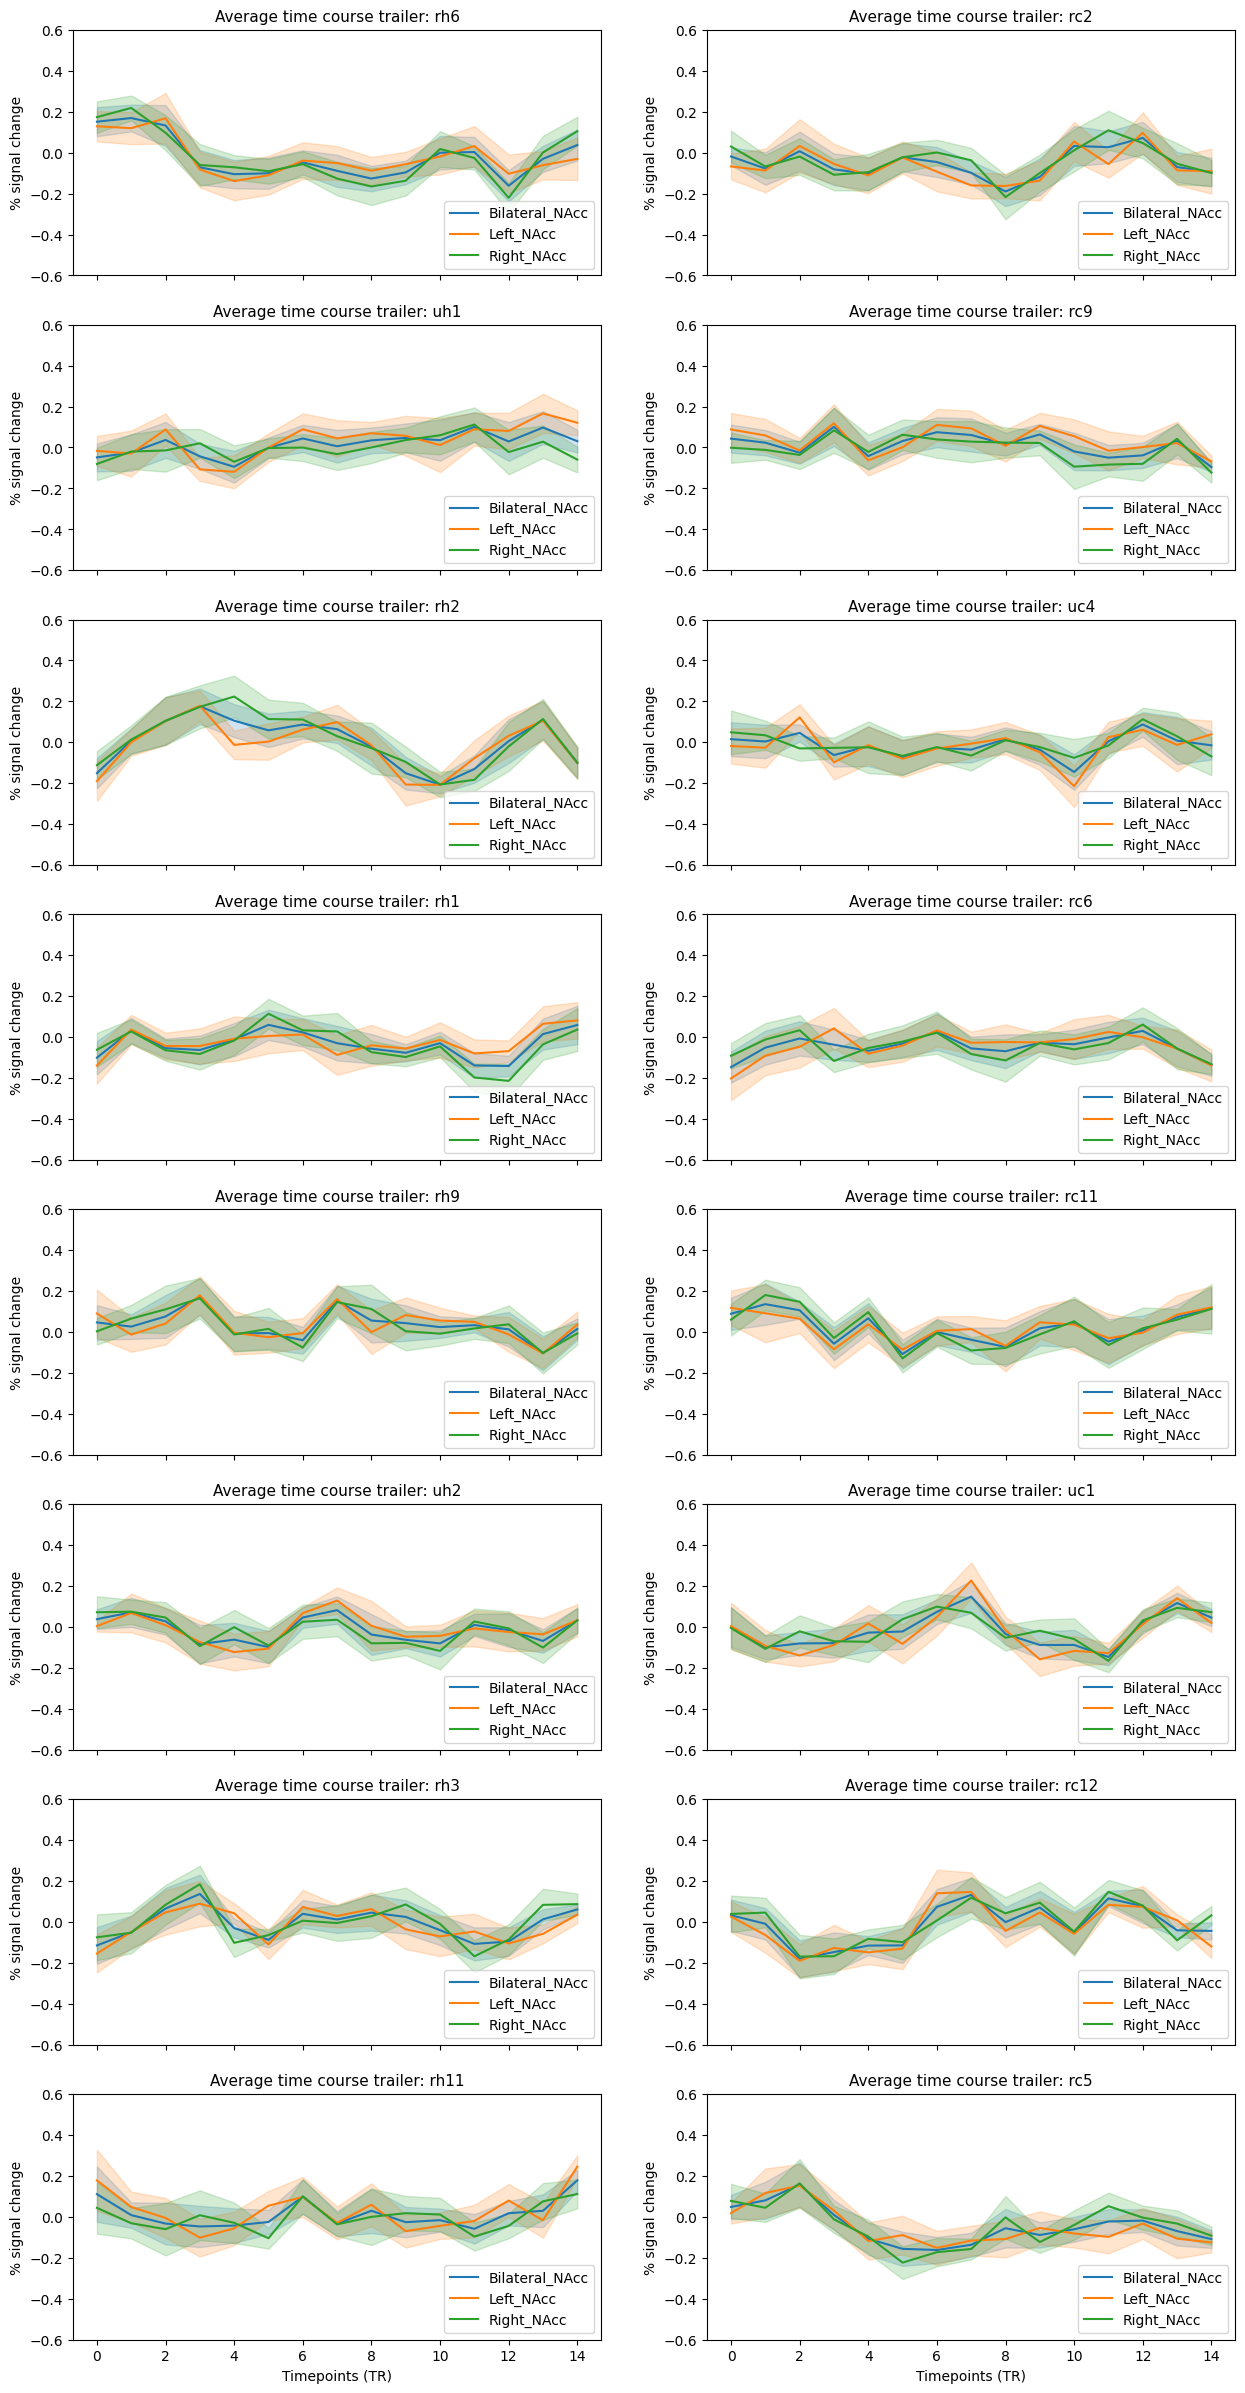

In [41]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

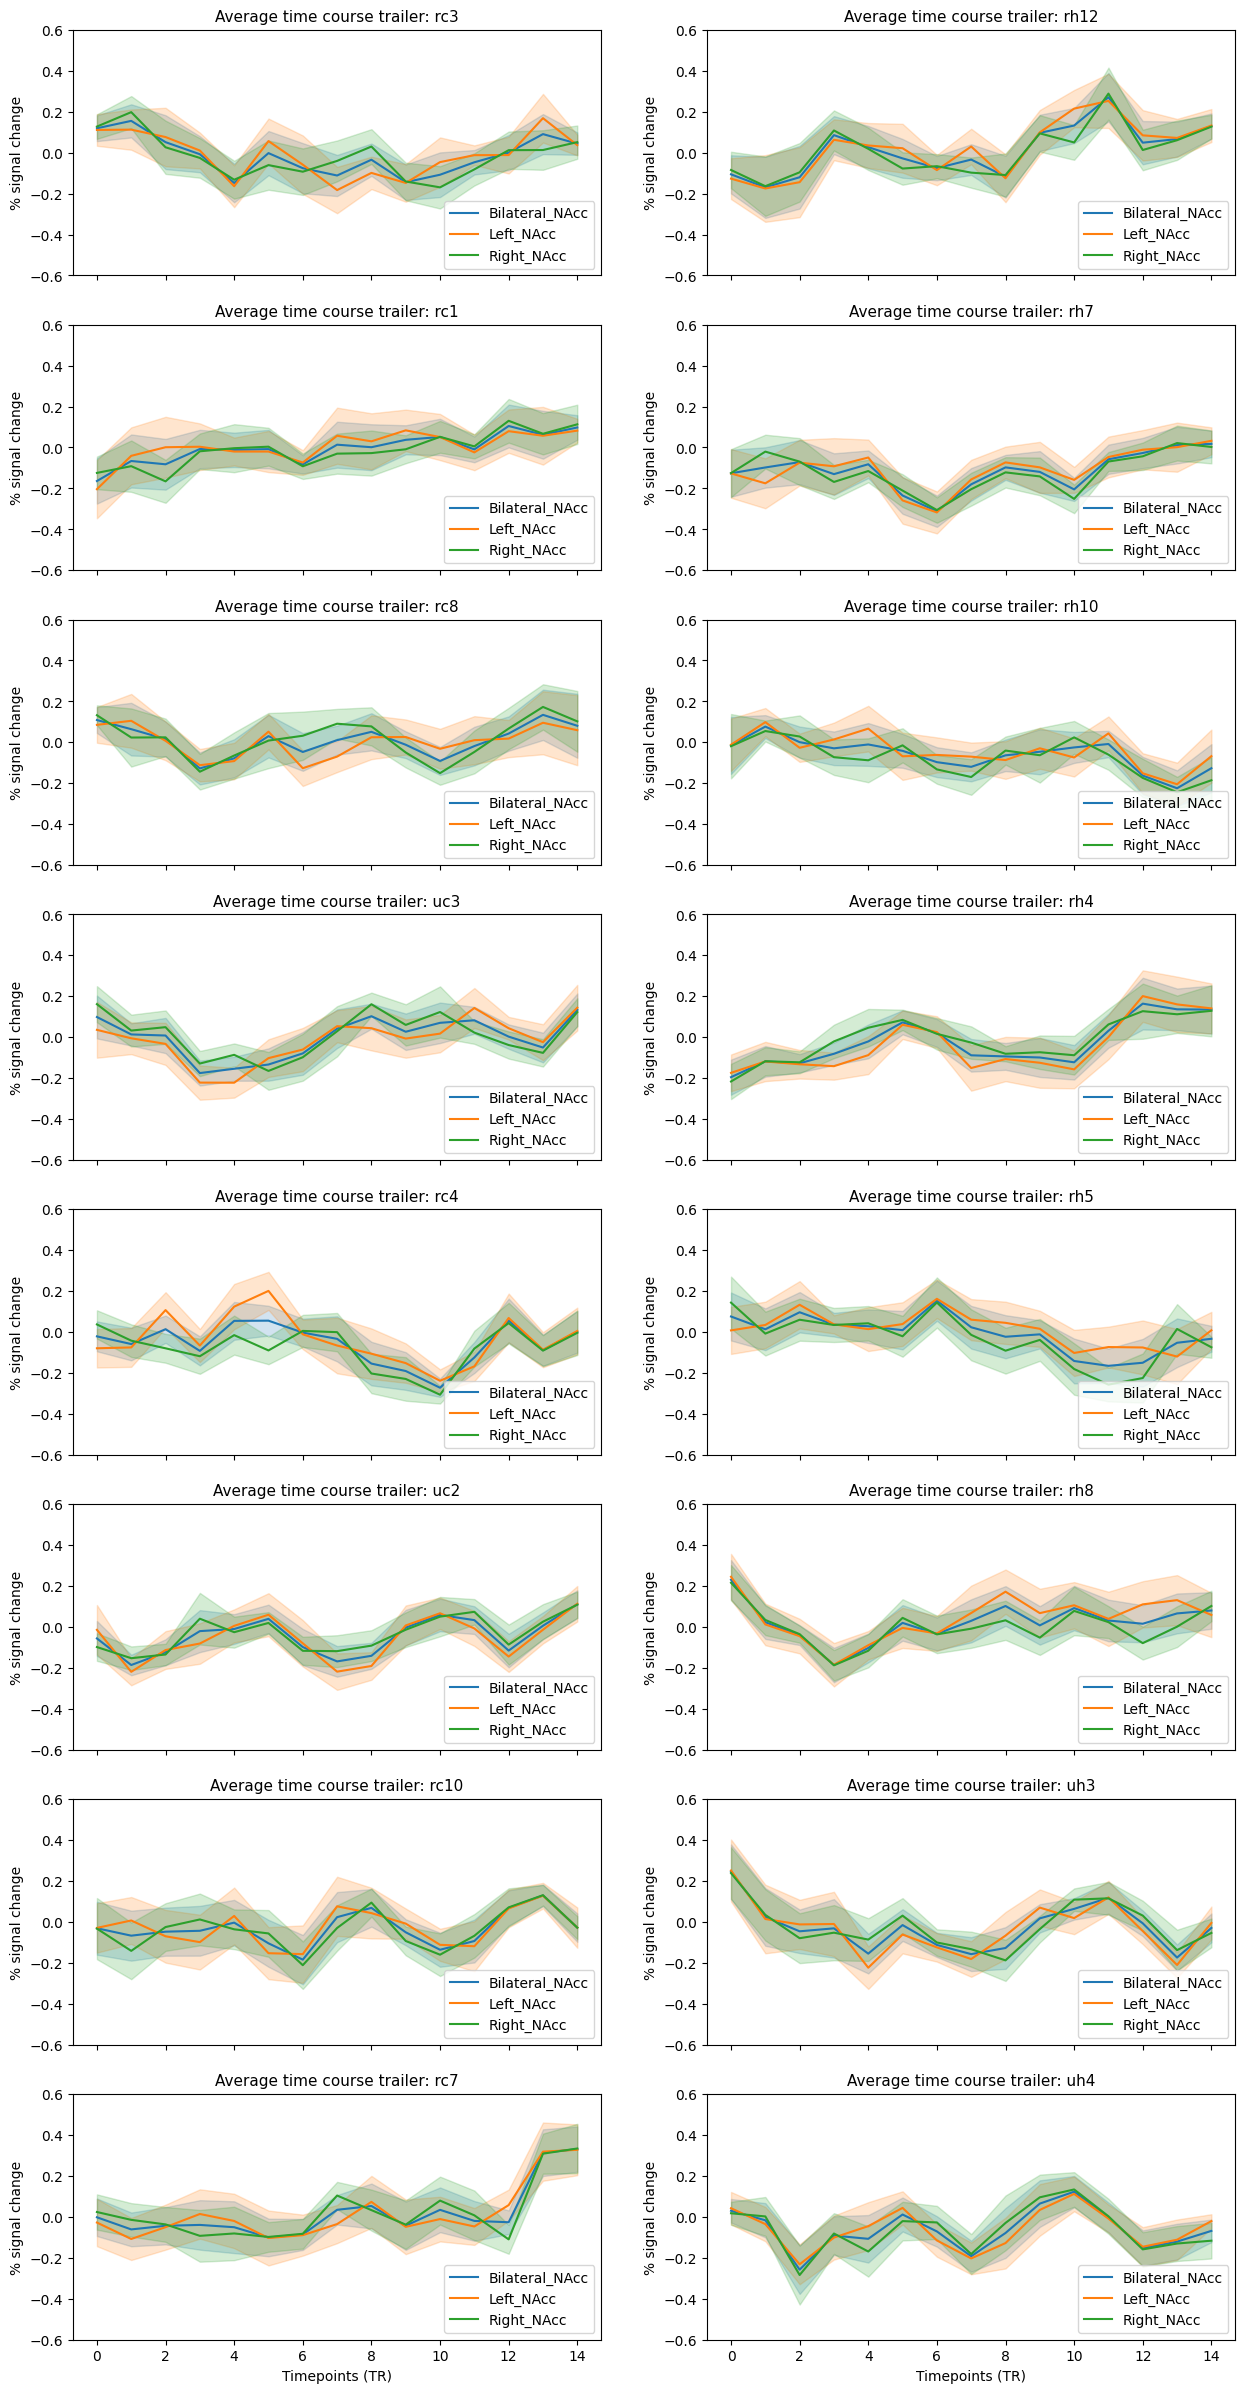

In [42]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_NAcc_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

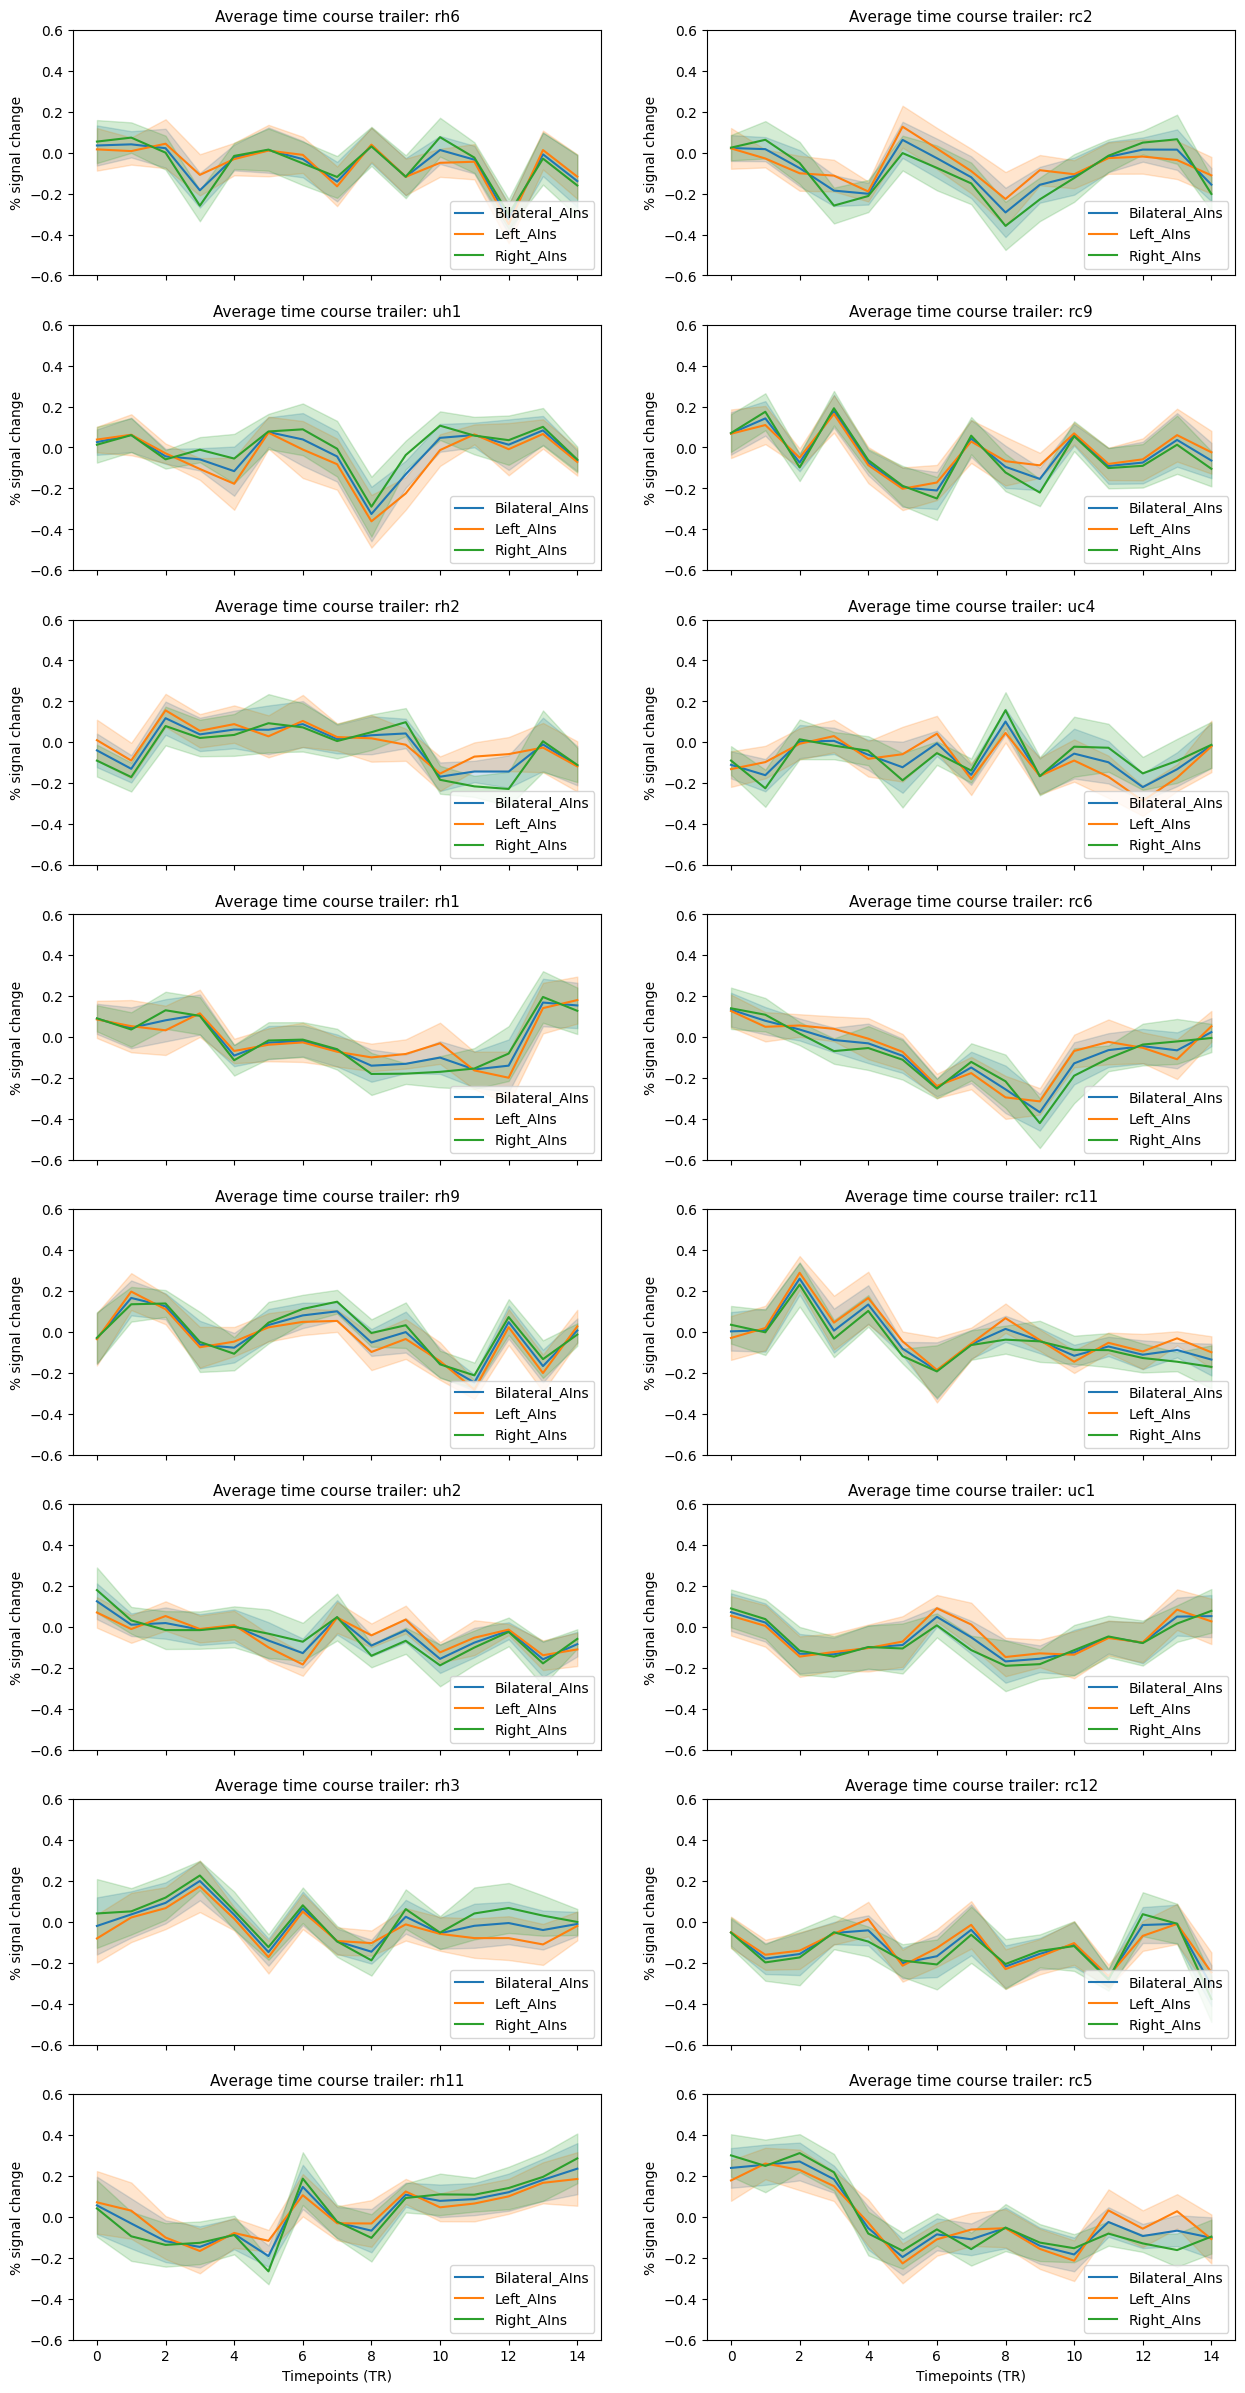

In [43]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

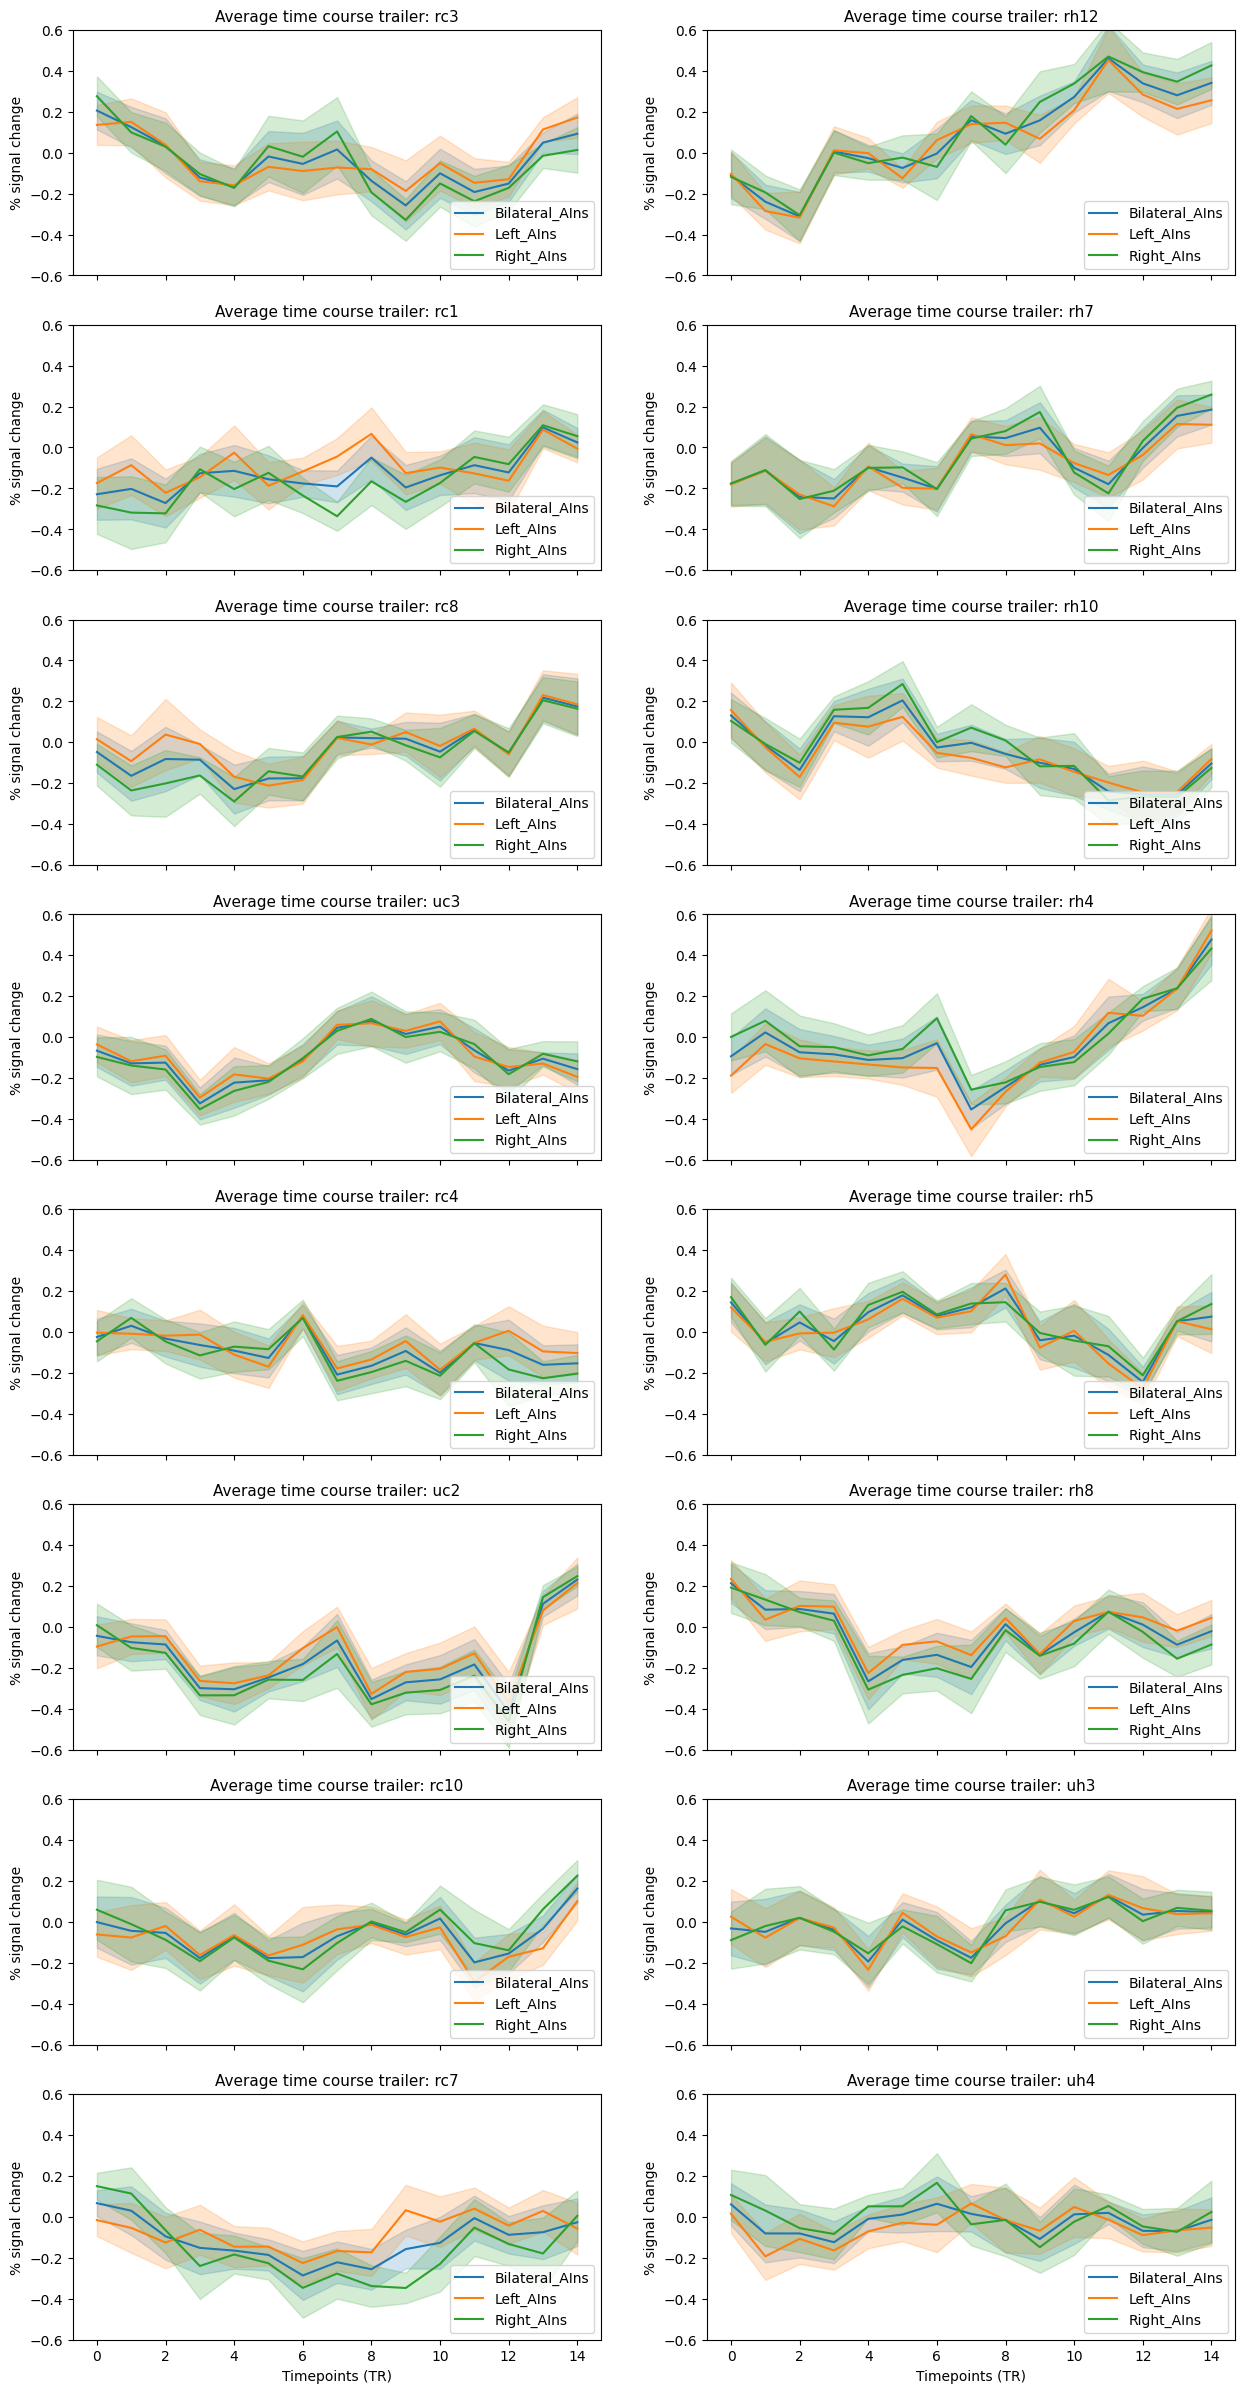

In [44]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_AIns_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

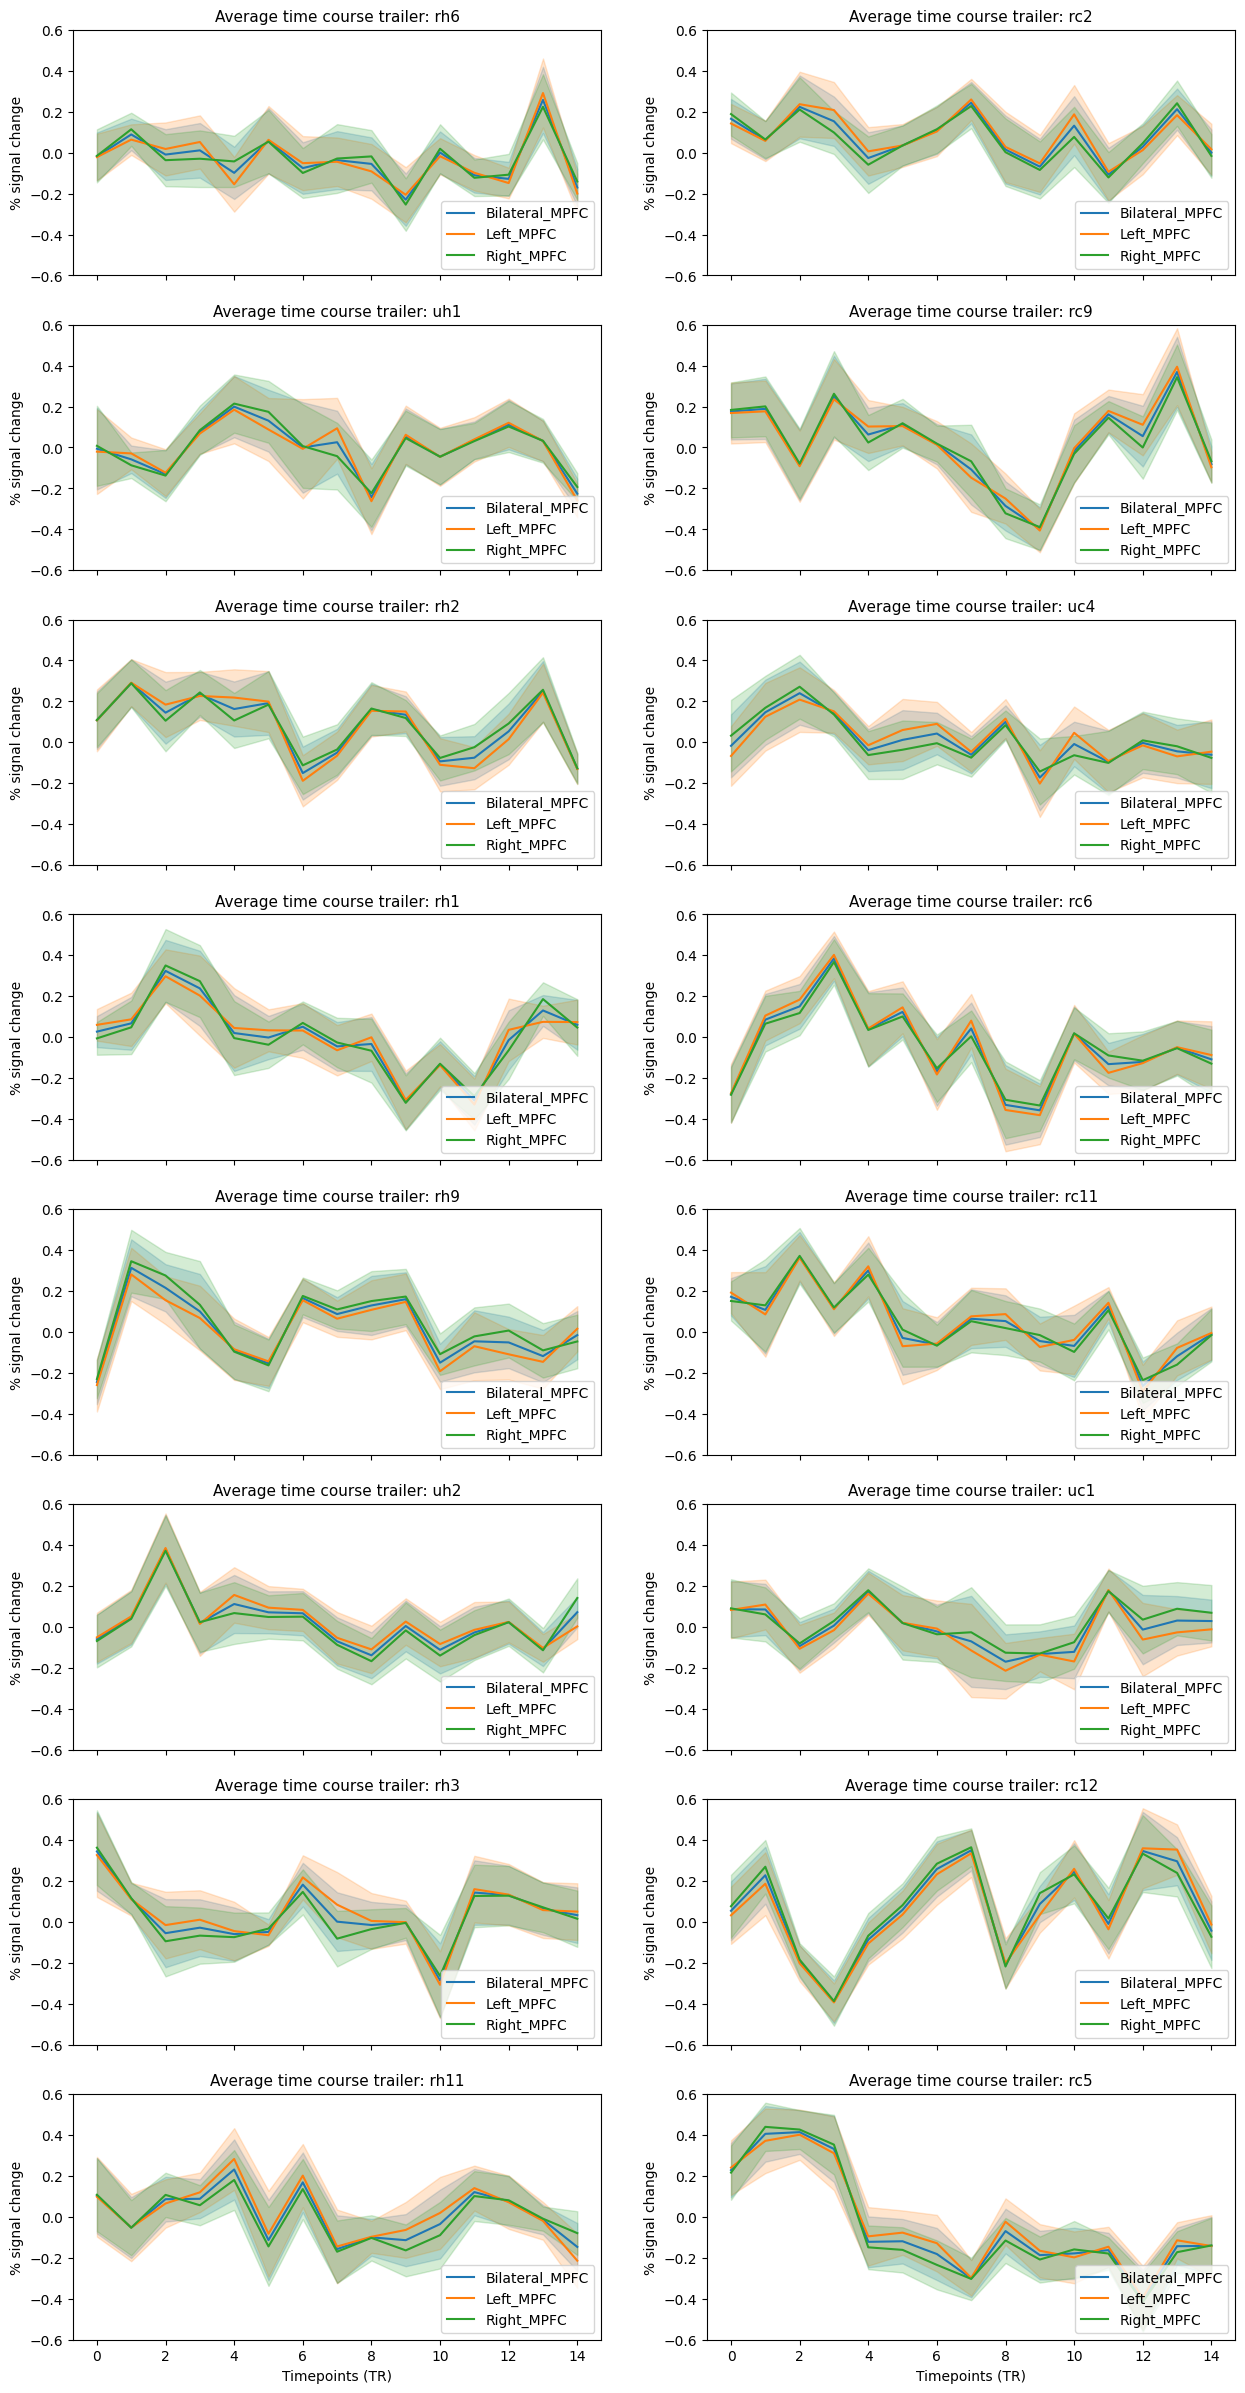

In [45]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r1_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r1_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

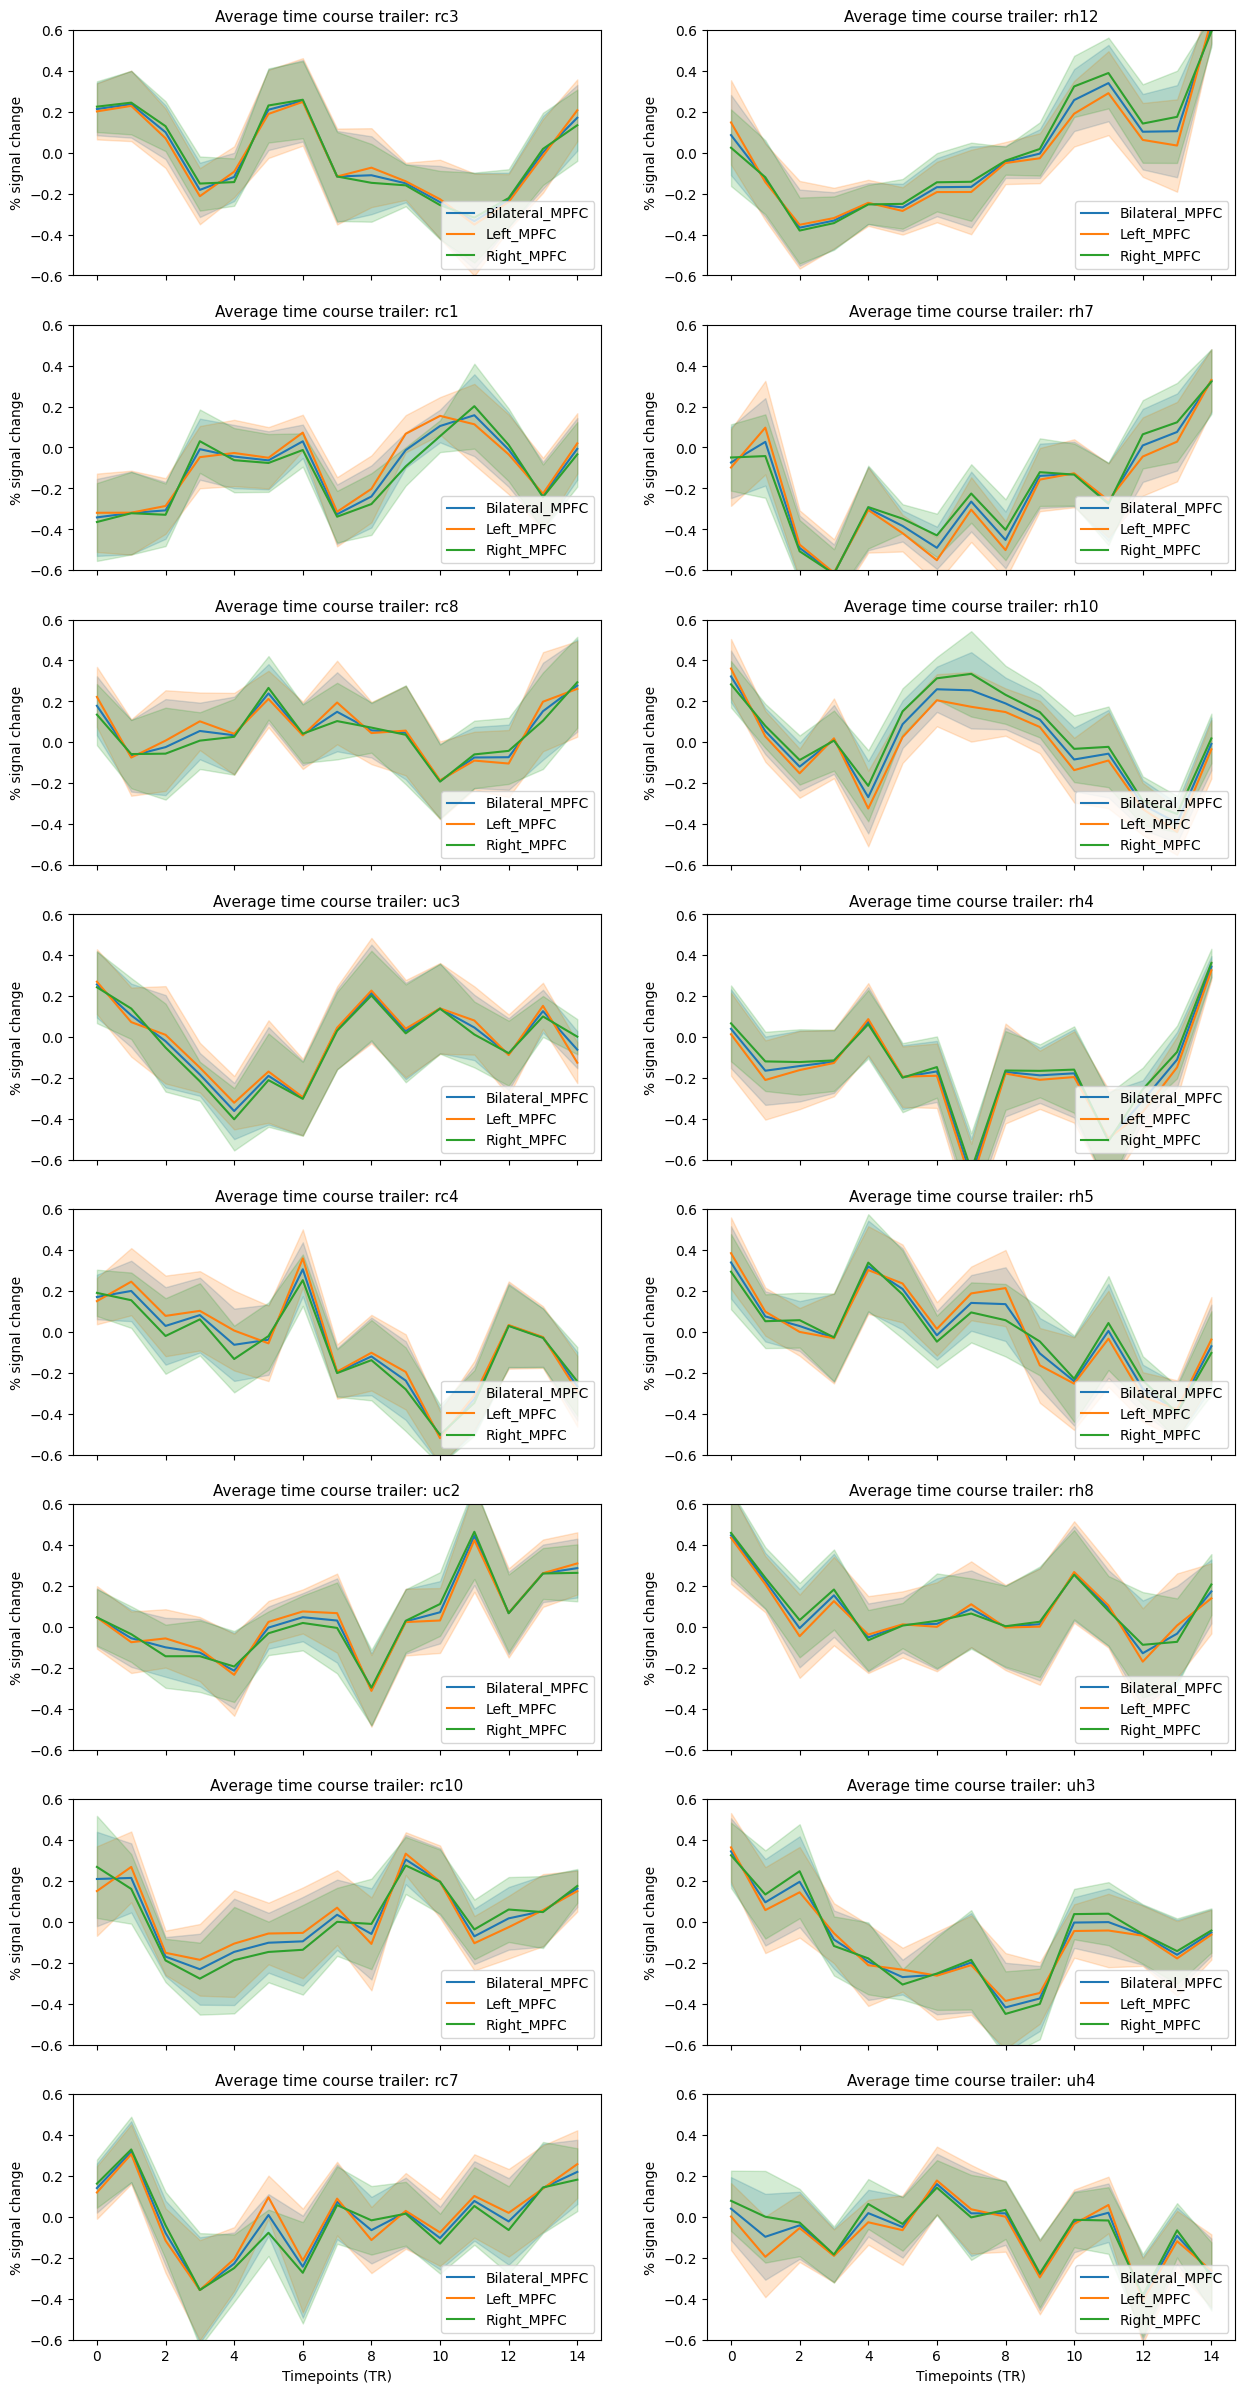

In [46]:
fig, axs = plt.subplots(8, 2, figsize=(15, 30), sharex=True)

runner = 0

for id in range(8):

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 0], errorbar="se")
    axs[id, 0].legend(loc='lower right', fontsize=10)
    axs[id, 0].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 0].set_ylabel('% signal change')
    axs[id, 0].set_xlabel('Timepoints (TR)')
    axs[id, 0].set_ylim(-.6, .6)
    runner +=1

    sns.lineplot(data=all_subjects_MPFC_timecourse_df[r2_keys_sorted[runner]], x="TR", y="Signal", hue="ROI", legend="brief", ax=axs[id, 1], errorbar="se")
    axs[id, 1].legend(loc='lower right', fontsize=10)
    axs[id, 1].set_title("Average time course trailer: " + str(r2_keys_sorted[runner]), size=11)
    axs[id, 1].set_ylabel('% signal change')
    axs[id, 1].set_xlabel('Timepoints (TR)')
    axs[id, 1].set_ylim(-.6, .6)

    runner +=1

In [47]:
# Save each participants timecourse data and processed events to a csv files.

save_path = "/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData/"

for id_participant in range(len(particpants_list)):
    
    current_sub = "sub-" + particpants_list[id_participant]
    print("Processing and saving files for : "  + current_sub)

    participants_events[id_participant].to_csv(save_path + current_sub + "/" + current_sub + "_processed_events.csv", index=False)

    # Create empty dataframe for current participant.
    current_participant_df = pd.DataFrame(columns=["Participant"], data=np.repeat(current_sub, 15))

    for id_trailer in trailer_keys:

        for id_tr in range(15):

            col_label_NAcc = id_trailer + "_bNAcc"
            col_lable_AIns = id_trailer + "_bAIns"
            col_lable_MPFC = id_trailer + "_bMPFC"
            current_participant_df[col_label_NAcc] = participant_dictionaries[id_participant][id_trailer]["Bilateral_NAcc"]
            current_participant_df[col_lable_AIns] = participant_dictionaries[id_participant][id_trailer]["Bilateral_AIns"]
            current_participant_df[col_lable_MPFC] = participant_dictionaries[id_participant][id_trailer]["Bilateral_MPFC"]
    
    current_participant_df.to_csv(save_path + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv", index=False)


Processing and saving files for : sub-01
Processing and saving files for : sub-02
Processing and saving files for : sub-03
Processing and saving files for : sub-04
Processing and saving files for : sub-08
Processing and saving files for : sub-09
Processing and saving files for : sub-10
Processing and saving files for : sub-11
Processing and saving files for : sub-12
Processing and saving files for : sub-13


# Process all participants data

In [48]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData", os.O_RDONLY)


# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

root_path = os.getcwd()

Current working dir : /Users/luisalvarez/Documents/GitHub/RM_Thesis_Neuroforecasting/ProcessedData


In [51]:
all_cols = ['Participant', 'Trailer', 'Type', 'Onset', 'Offset', 'Duration', 'W_score', 'A_score',
       'F_score', 'NAcc_onset', 'AIns_onset', 'MPFC_onset', 'NAcc_middle',
       'AIns_middle', 'MPFC_middle', 'NAcc_offset', 'AIns_offset',
       'MPFC_offset']

all_subs_events_df = pd.DataFrame(columns = all_cols)

particpants_list = ["01", "02", "03", "04", "08", "09", "10", "11", "12", "13"]

# Loop through each participant's data.
for sub_num in particpants_list:

    current_sub = str("sub-" + sub_num)
    current_sub_events_path = root_path + "/" + current_sub + "/" + current_sub + "_processed_events.csv"
    current_sub_AIM_path = root_path + "/" + current_sub + "/" + current_sub + "_AIM_ROI_NeuralActivation.csv"

    current_sub_events_df = pd.read_csv(current_sub_events_path)
    current_sub_AIM_df = pd.read_csv(current_sub_AIM_path)

    trailer_keys = current_sub_events_df["Trailer"].unique().tolist()

    # Create empty lists to store the mean onset, middle, and offset activation for each ROI.
    NAcc_onset = []
    AIns_onset = []
    MPFC_onset = []

    NAcc_middle = []
    AIns_middle = []
    MPFC_middle = []

    NAcc_offset = []
    AIns_offset = []
    MPFC_offset = []

    for id_trailer in range(len(trailer_keys)):

        # Create keys to access AIM_df columns.
        NAcc_key = trailer_keys[id_trailer] + "_bNAcc" 
        AIns_key = trailer_keys[id_trailer] + "_bAIns"
        MPFC_key = trailer_keys[id_trailer] + "_bMPFC"

        # Calculate ROI mean onset (1-5 TRs) activation for each trailer. 
        # And append to the corresponding list.
        NAcc_onset.append(current_sub_AIM_df[NAcc_key][0:5].mean())
        AIns_onset.append(current_sub_AIM_df[AIns_key][0:5].mean())
        MPFC_onset.append(current_sub_AIM_df[MPFC_key][0:5].mean())

        # Calculate ROI mean middle (6-10 TRs) activation for each trailer.
        NAcc_middle.append(current_sub_AIM_df[NAcc_key][5:10].mean())
        AIns_middle.append(current_sub_AIM_df[AIns_key][5:10].mean())
        MPFC_middle.append(current_sub_AIM_df[MPFC_key][5:10].mean())

        # Calculate ROI mean offset (11-15 TRs) activation for each trailer.
        NAcc_offset.append(current_sub_AIM_df[NAcc_key][10:15].mean())
        AIns_offset.append(current_sub_AIM_df[AIns_key][10:15].mean())
        MPFC_offset.append(current_sub_AIM_df[MPFC_key][10:15].mean())

    # Append the mean activation to the current_sub_events_df.
    current_sub_events_df["NAcc_onset"] = NAcc_onset
    current_sub_events_df["AIns_onset"] = AIns_onset
    current_sub_events_df["MPFC_onset"] = MPFC_onset

    current_sub_events_df["NAcc_middle"] = NAcc_middle
    current_sub_events_df["AIns_middle"] = AIns_middle
    current_sub_events_df["MPFC_middle"] = MPFC_middle

    current_sub_events_df["NAcc_offset"] = NAcc_offset
    current_sub_events_df["AIns_offset"] = AIns_offset
    current_sub_events_df["MPFC_offset"] = MPFC_offset

    current_sub_events_df["Participant"] = np.repeat(current_sub_AIM_df["Participant"][0], len(trailer_keys))

    # Append the current_sub_events_df to the all_subs_events_df.
    all_subs_events_df = pd.concat([all_subs_events_df, current_sub_events_df], ignore_index=True)

all_subs_events_df.head(40)
#all_subs_events_df.to_csv(root_path + "/AllSubs_NeuralActivation.csv", index=False)

Participant Trailer    Type  Onset  Offset Duration W_score A_score  \
0       sub-01     rh6  Horror   12.0    42.0       30       2       2   
1       sub-01     uh1  Horror   60.0    90.0       30       4       2   
2       sub-01     rc2  Comedy  108.0   138.0       30       4       4   
3       sub-01     rh2  Horror  152.0   182.0       30       2       3   
4       sub-01     rh1  Horror  196.0   226.0       30       1       2   
5       sub-01     rc9  Comedy  244.0   274.0       30       1       1   
6       sub-01     uc4  Comedy  288.0   318.0       30       2       3   
7       sub-01     rh9  Horror  332.0   362.0       30       3       3   
8       sub-01     uh2  Horror  376.0   406.0       30       1       2   
9       sub-01     rc6  Comedy  420.0   450.0       30       4       4   
10      sub-01     rh3  Horror  468.0   498.0       30       3       3   
11      sub-01    rc11  Comedy  512.0   542.0       30       4       4   
12      sub-01     uc1  Comedy  560.0   590.0       30       3       3   
13      sub-01    rh11  Horror  608.0   638.0       30       4       2   
14      sub-01    rc12  Comedy  656.0   686.0       30       2       3   
15      sub-01     rc5  Comedy  700.0   730.0       30       3       2   
16      sub-01     rc3  Comedy   12.0    42.0       30       2       3   
17      sub-01    rh12  Horror   60.0    90.0       30       2       1   
18      sub-01     rc1  Comedy  108.0   138.0       30       3       3   
19      sub-01     rh7  Horror  152.0   182.0       30       4       3   
20      sub-01     rc8  Comedy  200.0   230.0       30       3       3   
21      sub-01     uc3  Comedy  244.0   274.0       30       1       2   
22      sub-01    rh10  Horror  288.0   318.0       30       4       1   
23      sub-01     rc4  Comedy  332.0   362.0       30       1       2   
24      sub-01     rh4  Horror  380.0   410.0       30       2       2   
25      sub-01     uc2  Comedy  428.0   458.0       30       3       3   
26      sub-01     rh5  Horror  476.0   506.0       30       3       1   
27      sub-01     rh8  Horror  520.0   550.0       30       4       1   
28      sub-01    rc10  Comedy  568.0   598.0       30       1       1   
29      sub-01     uh3  Horror  616.0   646.0       30       1       1   
30      sub-01     rc7  Comedy  660.0   690.0       30       3       4   
31      sub-01     uh4  Horror  704.0   734.0       30       2       2   
32      sub-02     rh6  Horror   12.0    42.0       30       4       3   
33      sub-02     uh1  Horror   60.0    90.0       30       3       2   
34      sub-02     rc2  Comedy  108.0   138.0       30       3       3   
35      sub-02     rh2  Horror  152.0   182.0       30       3       2   
36      sub-02     rh1  Horror  196.0   226.0       30       4       4   
37      sub-02     rc9  Comedy  244.0   274.0       30       2       3   
38      sub-02     uc4  Comedy  288.0   318.0       30       3       3   
39      sub-02     rh9  Horror  332.0   362.0       30       3       4   

   F_score  NAcc_onset  AIns_onset  MPFC_onset  NAcc_middle  AIns_middle  \
0        3    0.064028   -0.012822   -0.104079    -0.156389    -0.275769   
1        2    0.195911   -0.153064    0.175629     0.053054    -0.191955   
2        2   -0.182903   -0.048902    0.186998     0.261559     0.245798   
3        3   -0.182863   -0.185661   -0.188561    -0.218827    -0.169152   
4        3    0.122135    0.386532    0.410013    -0.017498    -0.087327   
5        1    0.006867    0.130257   -0.259946    -0.055857    -0.231964   
6        1   -0.111216   -0.281512   -0.276925    -0.295686    -0.308353   
7        3    0.208615   -0.072168    0.199211     0.361712     0.159581   
8        4    0.010735   -0.196096    0.440063     0.202211     0.071607   
9        2    0.206996    0.064719    0.829383    -0.207265    -0.446947   
10       3    0.119151    0.318387    0.158778     0.020550    -0.099372   
11       2    0.247793    0.396938    0.286189    -0.157